Data Increase + Batch normalization + Dropout + Stochastic Depth

# Libraries

In [25]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from einops import rearrange

import torch.optim
import torch.utils.data
#!pip install torchvision==0.11.1
import torchvision.transforms as transforms
import torchvision.datasets as datasets

# Datasets

In [27]:
from timm.models.layers import DropPath

In [28]:
PATH="datasets"

# Model

In [29]:
def imgs_to_SoP(imgs):
    shape = imgs.shape
    height = shape[-2]
    width = shape[-1]
    batch = shape[0]
    
    ind_w = torch.arange(width)/(width-1)-0.5
    ind_h = torch.arange(height)/(height-1)-0.5
    ind = torch.stack(torch.meshgrid(ind_w,ind_h,indexing = 'ij'),dim = -1).reshape(2,height,width)
    
    batch_ind = ind.repeat(batch,1,1,1)
    #flat_imgs = imgs.flatten(start_dim=len(shape)-2) #laisser en b c h w ?
    
    SoP = torch.cat((imgs,batch_ind),dim=1)
    
    return SoP

In [30]:
class GroupNorm(nn.GroupNorm):
    """
    Group Normalization with 1 group.
    Input: tensor in shape [B, C, H, W]
    """
    def __init__(self, num_channels, **kwargs):
        super().__init__(1, num_channels, **kwargs)

In [31]:
class PointReducer(nn.Module):
    def __init__(self, in_chan, out_chan, kernel_size=2, stride=2, norm_layer=None):
        super().__init__()
        self.conv2d = nn.Conv2d(in_chan, out_chan, kernel_size, stride)
        self.norm = norm_layer(out_chan) if norm_layer else nn.Identity()

    def forward(self,input):
        out = self.conv2d(input)
        out = self.norm(out)
        return out

In [32]:
def pairwise_cosine_sim(x1, x2):
    x1_norm = F.normalize(x1, dim=-1) 
    x2_norm = F.normalize(x2, dim=-1)
    
    sim = x1_norm @ x2_norm.transpose(-2,-1) #to compute for each pair in the batch
    
    return sim

In [33]:
class Cluster(nn.Module):
    def __init__(self,in_channels,out_channels,heads,head_dim,proposal_w=2,proposal_h=2,fold_w=2,fold_h=2):
        super().__init__()
        
        self.heads = heads
        self.head_dim = head_dim
        self.fold_w = fold_w
        self.fold_h = fold_h
        
        self.fc1 = nn.Conv2d(in_channels,heads*head_dim,kernel_size = 1)
            #heads*head_dim -> we place the heads in the batch later
        self.fcv = nn.Conv2d(in_channels,heads*head_dim,kernel_size = 1)
        self.fc2 = nn.Conv2d(heads*head_dim,out_channels,kernel_size = 1)
        self.center_proposal = nn.AdaptiveAvgPool2d((proposal_w,proposal_h))
        
        self.alpha = nn.Parameter(torch.ones(1)) #initialisation bizarre
        self.beta = nn.Parameter(torch.zeros(1)) #initialisation bizarre
        
    def forward(self,x):
        """
        x : [b,c,h,w]
        """
        _,_,h,w = x.shape 
        
        val = self.fcv(x)
        x = self.fc1(x)

        # separating heads
        x = rearrange(x, "b (e c) h w -> (b e) c h w", e=self.heads)
        val = rearrange(val, "b (e c) h w -> (b e) c h w", e=self.heads) 
        
        #splitting patches 
        if self.fold_w>1 and self.fold_h>1:
            assert w%self.fold_w==0 and h%self.fold_h==0
            x = rearrange(x, "b c (f1 h) (f2 w) -> (b f1 f2) c h w", f1=self.fold_h, f2=self.fold_w)
            val = rearrange(val, "b c (f1 h) (f2 w) -> (b f1 f2) c h w", f1=self.fold_h, f2=self.fold_w)
        _,_,h,w = x.shape
        #computing cluster centers
        cluster_centers = self.center_proposal(x) #(b,c,Cw,Ch)
        center_values = rearrange(self.center_proposal(val) , 'b c h w -> b (h w) c') #(b,Cw*Ch,c) = (b,m,c)
        
        b,c,_,_ = cluster_centers.shape

        #computing similarity
        sim = torch.sigmoid(self.beta + self.alpha*pairwise_cosine_sim(cluster_centers.reshape(b,c,-1).permute(0,2,1), x.reshape(b,c,-1).permute(0,2,1))) #(b,Cw*Ch,h*w) = (b,m,n)
        sim_max, sim_argmax = sim.max(dim = 1, keepdim = True)
        
        #assigning a cluster to each point
        mask = torch.zeros_like(sim) #(b,m,n)
        mask.scatter_(1, sim_argmax, 1.)
        sim= sim*mask
        
        #computing aggregated feature
        val = rearrange(val, 'b c h w -> b (h w) c')
        out = ((val.unsqueeze(dim=1)*sim.unsqueeze(dim=-1)).sum(dim=2) + center_values)/(mask.sum(dim=-1,keepdim=True)+ 1)
        
        out = (out.unsqueeze(dim=2)*sim.unsqueeze(dim=-1)).sum(dim=1)
        out = rearrange(out, "b (h w) c -> b c h w", h=h)
        
        #recovering splitted patches
        if self.fold_w>1 and self.fold_h>1:
            out = rearrange(out, "(b f1 f2) c h w -> b c (f1 h) (f2 w)", f1=self.fold_h, f2=self.fold_w)
        
        #regrouping heads
        out = rearrange(out, "(b e) c h w -> b (e c) h w", e=self.heads)
        out = self.fc2(out)

        return out

In [34]:
class MLP(nn.Module):
    def __init__(self,in_channels,hidden_channels,out_channels,act,dropout=0):
        super().__init__()
        
        layers = [nn.Conv2d(in_channels,hidden_channels,kernel_size=1),act()]
        if dropout:
            layers.append(nn.Dropout(dropout))
        layers += [nn.Conv2d(hidden_channels,out_channels,kernel_size=1),act()]
        
        self.net = nn.Sequential(*layers)
        
    def forward(self,x):
        out = self.net(x)
        return out

In [35]:
#add droppath ???
class ClusterBlock(nn.Module):
    
    def __init__(self,in_channels,act=nn.GELU,mlp_ratio=4,dropout=0,droppath=0,proposal_w=2,proposal_h=2,fold_w=2,fold_h=2,heads=4,head_dim=16,norm_layer=GroupNorm):
        super().__init__()
        
        #(in_channels,out_channels,heads,head_dim,proposal_w=2,proposal_h=2,fold_w=2,fold_h=2))
        self.cluster = Cluster(in_channels,in_channels,heads,head_dim,proposal_w,proposal_h,fold_w,fold_h)
        hidden_dim = int(mlp_ratio*in_channels)
        self.mlp = MLP(in_channels,hidden_dim,in_channels,act,dropout=dropout)
        self.norm1 = norm_layer(in_channels)
        self.norm2 = norm_layer(in_channels)
        
        self.droppath = DropPath(droppath)
        
    def forward(self,x):
        x = x + self.droppath(self.cluster(self.norm1(x))) #skip conn
        out = x + self.droppath(self.mlp(self.norm2(x))) #skip conn
        return out

In [36]:
class BasicBlock(nn.Module):
    def __init__(self,in_channels,out_channels,N=1,norm_layer=GroupNorm,dropout=0,droppath=0):
        super().__init__()
        self.point_red = PointReducer(in_channels,out_channels)
        layers = []
        for i in range(N):
            layers.append(ClusterBlock(out_channels,norm_layer=norm_layer,dropout=dropout,droppath=droppath))
        self.cluster_b = nn.Sequential(*layers)
    
    def forward(self,x):
        x = self.point_red(x)
        x = self.cluster_b(x)
        return x

In [37]:
class Model(nn.Module):
    def __init__(self,embedding_sizes,num_classes,n_blocks=[1,1,1,1],norm_layer=GroupNorm,dropout=0,droppath=0):
        super().__init__()
        layers = []
        in_channels = 5
        
        #for out_channels in embedding_sizes:
            #layers.append(BasicBlock(in_channels,out_channels,norm_layer=norm_layer,dropout=dropout))
            #in_channels = out_channels


        for stage,out_channels in enumerate(embedding_sizes):
            N = n_blocks[stage]
            layers.append(BasicBlock(in_channels,out_channels,N=N,norm_layer=norm_layer,dropout=dropout,droppath=droppath))
            in_channels = out_channels


        
        self.feature_extractor = nn.Sequential(*layers)
        self.clf = nn.Linear(embedding_sizes[-1],num_classes)
        self.old_shape = None


    def imgs_to_SoP(self,imgs):
        """
        Transform a batch of images to a bacth of sets of points

        imgs : torch.Tensor([batch,chan,height,width])
        return : torch.Tensor([batch,chan+2,height*width])
        """
        shape = imgs.shape
        if self.old_shape != shape:
            self.old_shape = shape
            height = shape[-2]
            width = shape[-1]
            batch = shape[0]
            
            ind_w = torch.arange(width)/(width-1)-0.5
            ind_h = torch.arange(height)/(height-1)-0.5
            ind = torch.stack(torch.meshgrid(ind_w,ind_h,indexing = 'ij'),dim = -1).reshape(2,height,width)

            self.batch_ind = ind.repeat(batch,1,1,1)
        
        device = imgs.device
        #flat_imgs = imgs.flatten(start_dim=len(shape)-2)
        SoP = torch.cat((imgs,self.batch_ind.to(device)),dim=1) #might need to clone
        
        return SoP

    def forward(self,input):
        SoP = self.imgs_to_SoP(input)
        features = self.feature_extractor(SoP)
        features = torch.mean(features, dim = (2,3))
        yhat = self.clf(features)
        return yhat

# Tests

In [41]:
def main_10(model,n_epochs,device):
    cuda = True

    batch_size = 64
    train_dataset = datasets.CIFAR10(PATH, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor (), # Transform the PIL image to a torch.Tensor
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        transforms.RandomErasing(),
        transforms.RandomHorizontalFlip(),
    ]))
    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=1)
    
    test_dataset = datasets.CIFAR10(PATH, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor (), # Transform the PIL image to a torch.Tensor
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]))
    test_loader = torch.utils.data.DataLoader(test_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=1)
    

    Loss = nn.CrossEntropyLoss(label_smoothing=0.1)
    optim = torch.optim.AdamW(model.parameters())
    
    List_Loss = []

    for epoch in range(n_epochs):
        model.train()
        losses = []
        for X,y in train_loader:
            X,y = X.to(device), y.to(device)
            optim.zero_grad()
            
            yhat = model(X)

            l = Loss(yhat,y)
            l.backward()
            
            optim.step()
            losses.append(l.detach().cpu())
        if epoch % 10 == 0:
            acc = 0
            total = 0
            model.eval()
            for X,y in test_loader:
                X,y = X.to(device), y.to(device)
                yhat = model(X)

                y_pred = torch.argmax(yhat,dim = 1)
                acc += torch.sum(y==y_pred)
                total += len(y)
                #l = Loss(yhat,y)
            
        List_Loss.append(torch.mean(torch.stack(losses)).detach().cpu())
        if epoch % 10 == 0:
            print(f"epoch n°{epoch} : loss = {List_Loss[-1]}, acc = {acc.item()/total}")
        else:
            print(f"epoch n°{epoch} : loss = {List_Loss[-1]}")
    
    
    plt.plot(range(n_epochs),List_Loss)


In [42]:
def main_100(model,n_epochs,device):
    cuda = True

    batch_size = 64
    train_dataset = datasets.CIFAR100(PATH, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor (), # Transform the PIL image to a torch.Tensor
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        transforms.RandomErasing(),
        transforms.RandomHorizontalFlip(),
    ]))
    train_loader = torch.utils.data.DataLoader(train_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    
    test_dataset = datasets.CIFAR100(PATH, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor (), # Transform the PIL image to a torch.Tensor
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]))
    test_loader = torch.utils.data.DataLoader(test_dataset,
                        batch_size=batch_size, shuffle=True, pin_memory=cuda, num_workers=2)
    

    Loss = nn.CrossEntropyLoss(label_smoothing=0.1)
    optim = torch.optim.AdamW(model.parameters())
    
    List_Loss = []

    for epoch in range(n_epochs):
        model.train()
        losses = []
        for X,y in train_loader:
            X,y = X.to(device), y.to(device)
            optim.zero_grad()
            
            yhat = model(X)

            l = Loss(yhat,y)
            l.backward()
            optim.step()
            losses.append(l.detach().cpu())
        if epoch % 10 == 0:
            acc = 0
            total = 0
            model.eval()
            for X,y in test_loader:
                X,y = X.to(device), y.to(device)
                yhat = model(X)

                y_pred = torch.argmax(yhat,dim = 1)
                acc += torch.sum(y==y_pred)
                total += len(y)
                #l = Loss(yhat,y)
            
        List_Loss.append(torch.mean(torch.stack(losses)).detach().cpu())
        
        if epoch % 10 == 0:
            print(f"epoch n°{epoch} : loss = {List_Loss[-1]}, acc = {acc.item()/total}")
        else:
            print(f"epoch n°{epoch} : loss = {List_Loss[-1]}")
    
    plt.plot(range(n_epochs),List_Loss)


Files already downloaded and verified
Files already downloaded and verified
epoch n°0 : loss = 1.9176921844482422, acc = 0.4228
epoch n°1 : loss = 1.7274186611175537
epoch n°2 : loss = 1.6373670101165771
epoch n°3 : loss = 1.5685877799987793
epoch n°4 : loss = 1.5161640644073486
epoch n°5 : loss = 1.4714592695236206
epoch n°6 : loss = 1.4424479007720947
epoch n°7 : loss = 1.4168691635131836
epoch n°8 : loss = 1.394374966621399
epoch n°9 : loss = 1.3739222288131714
epoch n°10 : loss = 1.3636596202850342, acc = 0.6641
epoch n°11 : loss = 1.34642493724823
epoch n°12 : loss = 1.331734299659729
epoch n°13 : loss = 1.3183130025863647
epoch n°14 : loss = 1.3105372190475464
epoch n°15 : loss = 1.2972562313079834
epoch n°16 : loss = 1.2869458198547363
epoch n°17 : loss = 1.2813681364059448
epoch n°18 : loss = 1.2688915729522705
epoch n°19 : loss = 1.2592875957489014
epoch n°20 : loss = 1.255586862564087, acc = 0.7029
epoch n°21 : loss = 1.2469255924224854
epoch n°22 : loss = 1.241113305091858
e

epoch n°200 : loss = 0.9632103443145752, acc = 0.7891
epoch n°201 : loss = 0.9630237221717834
epoch n°202 : loss = 0.9618170261383057
epoch n°203 : loss = 0.9600973725318909
epoch n°204 : loss = 0.9600725769996643
epoch n°205 : loss = 0.9586653113365173
epoch n°206 : loss = 0.9602336287498474
epoch n°207 : loss = 0.9561983942985535
epoch n°208 : loss = 0.9561014175415039
epoch n°209 : loss = 0.9611821174621582
epoch n°210 : loss = 0.9575533866882324, acc = 0.7783
epoch n°211 : loss = 0.9569807648658752
epoch n°212 : loss = 0.9567500352859497
epoch n°213 : loss = 0.9547895789146423
epoch n°214 : loss = 0.9548159837722778
epoch n°215 : loss = 0.9534826278686523
epoch n°216 : loss = 0.9540150165557861
epoch n°217 : loss = 0.9527372717857361
epoch n°218 : loss = 0.9555915594100952
epoch n°219 : loss = 0.9540790319442749
epoch n°220 : loss = 0.9494348168373108, acc = 0.7795
epoch n°221 : loss = 0.9539807438850403
epoch n°222 : loss = 0.9525138139724731
epoch n°223 : loss = 0.953689455986023

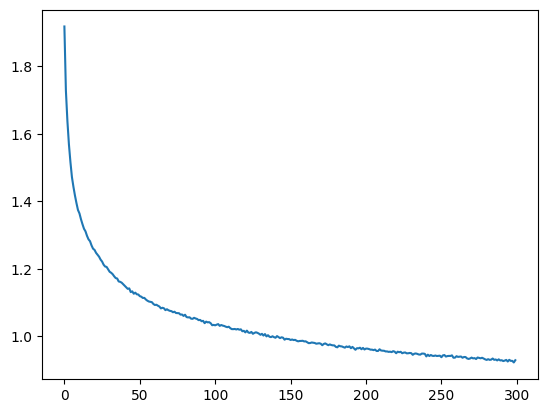

In [43]:
# With all the normalizations
n_blocks = [3,4,5,2]
embedding_sizes = [16,32,64,128]
num_classes = 10
device = 'cuda' #if torch.cuda.is_available() else 'cpu'
model_cifar10 = Model(embedding_sizes,num_classes,n_blocks=n_blocks,dropout=0.5,droppath=0.1).to(device)
main_10(model_cifar10,300,device)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting datasets\cifar-100-python.tar.gz to datasets
Files already downloaded and verified
epoch n°0 : loss = 4.111911773681641, acc = 0.1398
epoch n°1 : loss = 3.7891690731048584
epoch n°2 : loss = 3.630134105682373
epoch n°3 : loss = 3.523590087890625
epoch n°4 : loss = 3.4290108680725098
epoch n°5 : loss = 3.358656883239746
epoch n°6 : loss = 3.293917417526245
epoch n°7 : loss = 3.2365167140960693
epoch n°8 : loss = 3.181985855102539
epoch n°9 : loss = 3.1401891708374023
epoch n°10 : loss = 3.093472480773926, acc = 0.3442
epoch n°11 : loss = 3.061471700668335
epoch n°12 : loss = 3.0257067680358887
epoch n°13 : loss = 2.992666482925415
epoch n°14 : loss = 2.9673850536346436
epoch n°15 : loss = 2.9437527656555176
epoch n°16 : loss = 2.918692111968994
epoch n°17 : loss = 2.893883466720581
epoch n°18 : loss = 2.8755428791046143
epoch n°19 : loss = 2.858258008956909
epoch n°20 : loss = 2.836364507675171, acc = 0.406
epoch n°21 : loss = 2.819180488586426
epoch n°22 : loss = 2.804329633

epoch n°201 : loss = 2.213488817214966
epoch n°202 : loss = 2.214848518371582
epoch n°203 : loss = 2.206744909286499
epoch n°204 : loss = 2.2160582542419434
epoch n°205 : loss = 2.206329345703125
epoch n°206 : loss = 2.209571361541748
epoch n°207 : loss = 2.2087950706481934
epoch n°208 : loss = 2.2046103477478027
epoch n°209 : loss = 2.2030770778656006
epoch n°210 : loss = 2.2053637504577637, acc = 0.4983
epoch n°211 : loss = 2.2041518688201904
epoch n°212 : loss = 2.2122159004211426
epoch n°213 : loss = 2.204498767852783
epoch n°214 : loss = 2.2010486125946045
epoch n°215 : loss = 2.1998329162597656
epoch n°216 : loss = 2.2040205001831055
epoch n°217 : loss = 2.197741985321045
epoch n°218 : loss = 2.193244457244873
epoch n°219 : loss = 2.1885085105895996
epoch n°220 : loss = 2.2031006813049316, acc = 0.498
epoch n°221 : loss = 2.2004919052124023
epoch n°222 : loss = 2.1875174045562744
epoch n°223 : loss = 2.193614959716797
epoch n°224 : loss = 2.1841888427734375
epoch n°225 : loss = 2

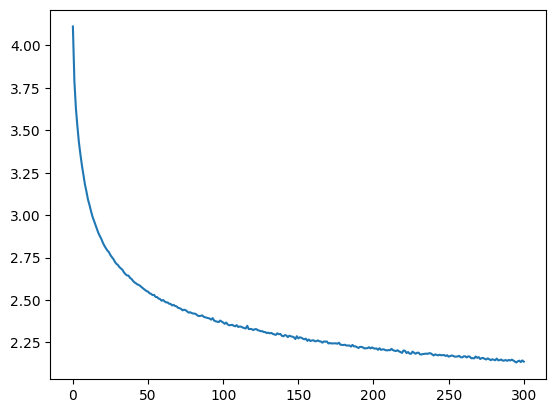

In [46]:
n_blocks = [3,4,5,2]
embedding_sizes = [16,32,64,128]
num_classes = 100
device = 'cuda' #if torch.cuda.is_available() else 'cpu'
model_cifar100 = Model(embedding_sizes,num_classes,n_blocks=n_blocks,dropout=0.5,droppath=0.1).to(device)
main_100(model_cifar100,301,device)